In [1]:
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

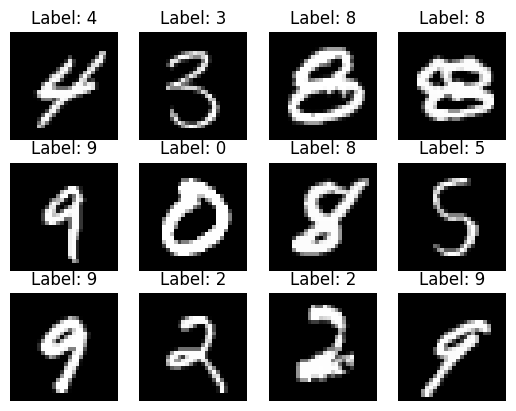

In [4]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert PIL Image to Tensor and rescales to [-1, 1]
    transforms.Normalize((0.5,), (0.5,))    # Normalize with mean=0.5, std=0.5
])

# Datasets
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# DataLoader
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Visualize
examples = iter(dataloader)
images, labels = next(examples)

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator
# input = random vector, output = fake image
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(in_features=nz, out_features=256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256, momentum=0.8),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512, momentum=0.8),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024, momentum=0.8),
            
            nn.Linear(1024, image_size*image_size),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights to mean=0, stdev=0.02.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): BatchNorm1d(1024, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

In [7]:
# Discriminator
# input = image, output = likelihood of image being real
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_size*image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

In [8]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Train on real batch of images
        netD.zero_grad()
        real_cpu = data[0].to(device)                                                   # Image
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)     # Generates all 1's
        # Forward pass real batch through Discriminator
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train on fake batch of images from generator
        noise = torch.randn(b_size, nz, device=device)          # Generate batch of latent vectors
        fake = netG(noise)                                      # Generate fake images
        label.fill_(fake_label)
        # Classify all fake batch with Discriminator
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # ---------------------
        #  Train Generator
        # ---------------------
        netG.zero_grad()
        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        # This is where the genrator is trying to trick discriminator into believing
        # the generated image is true (hence value of 1 for y)
        label.fill_(real_label)
        # Combine G and D and send the fake images generated by the G to the D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(dataloader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/5][0/469]	Loss_D: 1.3525	Loss_G: 0.6644	D(x): 0.5332	D(G(z)): 0.5148 / 0.5147
[0/5][50/469]	Loss_D: 0.3399	Loss_G: 1.4082	D(x): 0.9828	D(G(z)): 0.2721 / 0.2533
[0/5][100/469]	Loss_D: 0.5415	Loss_G: 1.1445	D(x): 0.7447	D(G(z)): 0.1883 / 0.4124
[0/5][150/469]	Loss_D: 1.4604	Loss_G: 0.3362	D(x): 0.9983	D(G(z)): 0.7132 / 0.7478
[0/5][200/469]	Loss_D: 0.8303	Loss_G: 0.8843	D(x): 0.7547	D(G(z)): 0.4154 / 0.4203
[0/5][250/469]	Loss_D: 1.0144	Loss_G: 1.2701	D(x): 0.6725	D(G(z)): 0.4544 / 0.2832
[0/5][300/469]	Loss_D: 0.9670	Loss_G: 1.1534	D(x): 0.7727	D(G(z)): 0.5044 / 0.3174
[0/5][350/469]	Loss_D: 1.0914	Loss_G: 0.7427	D(x): 0.5979	D(G(z)): 0.4337 / 0.4771
[0/5][400/469]	Loss_D: 1.1565	Loss_G: 1.1110	D(x): 0.7433	D(G(z)): 0.5730 / 0.3313
[0/5][450/469]	Loss_D: 1.2439	Loss_G: 0.6634	D(x): 0.5034	D(G(z)): 0.4189 / 0.5165
[1/5][0/469]	Loss_D: 1.2483	Loss_G: 1.3650	D(x): 0.7304	D(G(z)): 0.6027 / 0.2582
[1/5][50/469]	Loss_D: 1.2424	Loss_G: 0.8023	D(x): 0.5841	D(G(z)): 0.4988 / 0.4500
[1/5][100/

In [10]:
torch.save(netG.state_dict(), "./mnist-normal-gan-model.pt")

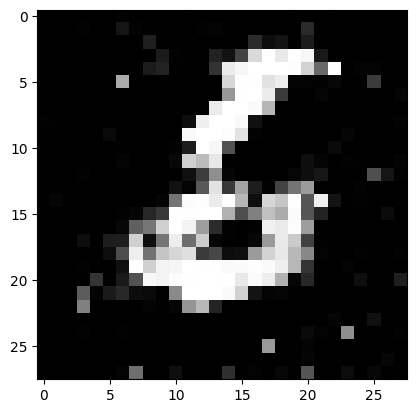

In [11]:
# Set the generator to evaluation mode
netG.eval()

# Generate a sample noise vector
sample_noise = torch.randn(1, nz, device=device)

# Generate an image from the noise vector
X = netG(sample_noise).detach().cpu()

# Plot the generated image
plt.imshow(X.view(image_size, image_size), cmap='gray')
plt.show()